# Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools as it
from numpy.linalg import inv

# Train, test, verification split

In [2]:
def train_test_verification_split(X, y, split_tr, split_v, split_te):    
    # define the data split
    total_count = X.shape[0]
    train_split = int(total_count * split_tr)
    ver_split = int(total_count * split_v) + train_split
    test_split = int(total_count * split_te) + ver_split
    return X[:train_split], y[:train_split], X[train_split:ver_split], y[train_split:ver_split], X[ver_split:test_split], y[ver_split:test_split]

# Read the data

### Run this for the SARCOS dataset

In [3]:
toy_problem = False
print("Using the SARCOS dataset...")
# read in csv file
df = pd.read_csv("sarcos_inv.csv", header=None)
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# split off the target variable
X, y = df.iloc[:,:-1], df.iloc[:,-1]
# normalise data
X = (X - X.min()) / (X.max() - X.min())

print("Splitting data...")
X_train, y_train, X_ver, y_ver, X_test, y_test = train_test_verification_split(X, y, 0.6, 0.2, 0.2)

Using the SARCOS dataset...
Splitting data...


# Utility class

This function computes the root mean squared error and the squared_error, given the actual data and the predicted data.

In [4]:
class util():
    @staticmethod
    def score(actual, prediction):
        return math.sqrt(np.mean((actual - prediction)**2))
    
    @staticmethod
    def squared_error(actual, prediction):
        return np.sum((actual - prediction)**2)
    
    @staticmethod
    def mean_absolute_error(actual, prediction):
        return np.sum(np.fabs(actual - prediction)) / actual.shape[0]

# Gaussian Process

This is my implementation of Gaussian Process.

In [5]:
# gets random subset of data to train on
def gp(X_train, y_train, X_, y_, l):
    randomize_train = np.arange(X_train.shape[0])
    np.random.shuffle(randomize_train)
    X_train = X_train[randomize_train]
    y_train = y_train[randomize_train]
    
    randomize_ = np.arange(X_.shape[0])
    np.random.shuffle(randomize_)
    X_ = X_[randomize_]
    y_ = y_[randomize_]
    
    split_tr = int(X_train.shape[0]*0.6)
 
    gp_X_train = X_train[:split_tr]
    gp_y_train = y_train[:split_tr]
    gp_X_test = X_
    gp_y_test = y_
    rmse, mae = gaussian_process(gp_X_train, gp_y_train, gp_X_test, gp_y_test, l)
    return rmse, mae

In [6]:
def gaussian_process(gp_X_train, gp_y_train, gp_X_test, gp_y_test, l):
    
    # define kernel
    def kernel(a, b, l):
        dist = np.sum(a**2, axis=1, keepdims=True) + np.sum(b**2, axis=1) - 2 * np.dot(a, b.T)
        return np.exp(-(1 / (2 * l**2)) * dist)

    # Apply the kernel function to the training data
    K = kernel(gp_X_train, gp_X_train, l)
    L = np.linalg.cholesky(K + 0.00000001*np.eye(gp_X_train.shape[0]))
    
    # Compute the mean for the test data
    K_s = kernel(gp_X_train, gp_X_test, l)
    Lk = np.linalg.solve(L, K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, gp_y_train))

    # Compute the standard deviation so we can plot it
    K_ss = kernel(gp_X_test, gp_X_test, l)
    var = np.diag(K_ss) - np.sum(Lk**2, axis=0)
    stdv = np.sqrt(var)

    rmse_test_gp = util.score(mu, gp_y_test)
    mae_test_gp = util.mean_absolute_error(gp_y_test, mu)
    print("The RMSE is {}".format(rmse_test_gp))
    return rmse_test_gp, mae_test_gp

#### Perform hyperparametering tuning with the verification set

In [7]:
print("This will take a little...")
rmse_arr = []
mae_arr = []

length_scale_opts = [1, 2, 3, 4, 5, 6]

for l in length_scale_opts:
    print("Trying {}...".format(l))
    rmse, mae = gp(X_train.values, y_train.values, X_ver.values, y_ver.values, l)
    rmse_arr.append(rmse)
    mae_arr.append(mae)

best_length_scale = length_scale_opts[np.argsort(rmse_arr)[0]]

Trying 1...
The RMSE is 5.493326512936831
Trying 2...
The RMSE is 2.6282133282956637
Trying 3...
The RMSE is 2.5445585741269876
Trying 4...
The RMSE is 2.643325672873203
Trying 5...
The RMSE is 2.723035251887347
Trying 6...
The RMSE is 2.8249701234062927


#### Predict with the test set using bagging

In [8]:
print("This will take a little less...")
# perform on the bagging with the test_set

rmse_arr = []
mae_arr = []
for i in range(5):
    rmse, mae = gp(X_train.values, y_train.values, X_test.values, y_test.values, l=2) #use best_length_scale
    rmse_arr.append(rmse)
    mae_arr.append(mae)

print("\nThe average RMSE for the test set is: ", np.mean(rmse_arr))
print("The average MAE for the test set is: ", np.mean(mae_arr))

This will take a little...
The RMSE is 2.5429919274314274
The RMSE is 2.618419589034504
The RMSE is 2.5984348266625417
The RMSE is 2.5587650687343024
The RMSE is 2.58123579498713

The average RMSE for the test set is:  2.579969441369981
The average MAE for the test set is:  1.724826046073717


#### Predict by training on one random subset of the data

In [ ]:
print(gaussian_process(X_train[:int(X_train.shape[0]*0.8)].values, y_train[:int(X_train.shape[0]*0.8)].values, X_test.values, y_test.values, 5))

# Implementation on the toy problem

In [9]:
f = lambda x: np.sin(0.9*x).flatten()

def kernel(a, b):
    sqdist = np.sum(a**2, axis=1, keepdims=True) + np.sum(b**2, axis=1) - 2 * np.dot(a, b.T)
    return np.exp(- 0.5 * (1/(0.9**2)) * sqdist)

X_train = np.random.uniform(-5, 5, size=(10,1))
y_train = f(X_train) 

X_test = np.linspace(-5, 5, 50).reshape(-1,1)
y_test = f(X_test)

K = kernel(X_train, X_train)
L = np.linalg.cholesky(K + 0.00005*np.eye(X_train.shape[0]))

# calculate the mean for the test data.
Lk = np.linalg.solve(L, kernel(X_train, X_test))
mean = np.dot(Lk.T, np.linalg.solve(L, y_train))

# calculate the variance for the test data.
K_ = kernel(X_test, X_test)
var = np.diag(K_) - np.sum(Lk**2, axis=0)
std = np.sqrt(var)

### Plot the graphs for the toy problem

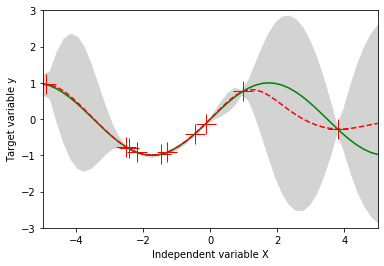

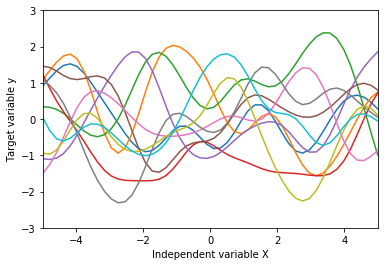

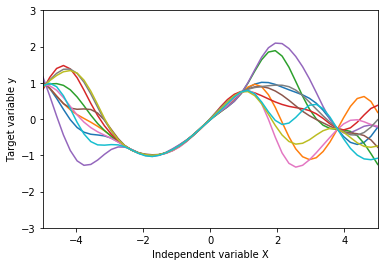

In [10]:
# plot the graph of the mean predictions
plt.plot(X_train, y_train, 'r+', ms=20)
plt.plot(X_test, f(X_test), 'g-')
plt.gca().fill_between(X_test.flat, mean-3*std, mean+3*std, color="lightgrey")
plt.plot(X_test, mean, 'r--')
plt.ylabel("Target variable y")
plt.xlabel("Independent variable X")
plt.axis([-5, 5, -3, 3])
plt.show()

# draw samples from prior
L = np.linalg.cholesky(K_ + 1e-6*np.eye(X_test.shape[0]))
f_prior = np.dot(L, np.random.normal(size=(X_test.shape[0],X_train.shape[0])))
plt.plot(X_test, f_prior)
plt.ylabel("Target variable y")
plt.xlabel("Independent variable X")
plt.axis([-5, 5, -3, 3])
plt.show()

# draw samples from posterior
L = np.linalg.cholesky(K_ + 1e-6*np.eye(X_test.shape[0]) - np.dot(Lk.T, Lk))
f_post = mean.reshape(-1,1) + np.dot(L, np.random.normal(size=(X_test.shape[0],10)))
plt.plot(X_test, f_post)
plt.ylabel("Target variable y")
plt.xlabel("Independent variable X")
plt.axis([-5, 5, -3, 3])
plt.show()